# ***Abstract :***
# This project is built to detect the depressive based on the tweet content user posted. 

***Recommend using colab to run my program***

In [1]:
# pip and import necessary file and library

! git clone https://github.com/Jingxuan-Bao/Tweet_Depression_Detection.git
! pip install contractions
! pip install joblib
! pip install files
! pip install tensorflow keras
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip

import pandas as pd
import re
import string
import nltk
import contractions
import numpy as np
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from google.colab import files
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

Cloning into 'Tweet_Depression_Detection'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 104 (delta 28), reused 85 (delta 14), pack-reused 0
Receiving objects: 100% (104/104), 27.12 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for files: filename=files-1.1.1-py3-none-any.whl size=3668 sha256=045aeb135b36900908f80d045e179a437d6f7a88c9f02123b6627139a5aca917
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Section 1: Load Data**

In [2]:
# read normal tweet data from my github

normal_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/normal_tweet.csv')
print(normal_tweet.head())

                                                text  label
0  in class. im EARLY. bummed RYAN SEACREST never...      0
1                                   i wanna go home       0
2                                  Our AC is broken       0
3  feels that the only place where Federer (&amp;...      0
4  @tommcfly Yeah tom, you are always the one tha...      0


In [3]:
normal_tweet

,text,label
0,in class. im EARLY. bummed RYAN SEACREST never...,0
1,i wanna go home,0
2,Our AC is broken,0
3,feels that the only place where Federer (&amp;...,0
4,"@tommcfly Yeah tom, you are always the one tha...",0
...,...,...
59995,It's 8:40am... I've been awake for nearly 2 ho...,0
59996,ughh mom`s making me cook dinner when i`m in t...,0
59997,"argh. netregistry is pissing me off today, pos...",0
59998,@gemmak500 It's amazing how many couples you s...,0


In [4]:
# read depressive tweet data from my github

depressive_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/depressive_tweet.csv')
print(depressive_tweet.head())

                                               Tweet
0  “Our world today so desperately hungers for ho...
1  “Go if you have to, but remember, don’t come b...
2  #Artists without an air of #loneliness , are #...
3  Getting a bit tired of losing my mind \n\n#bip...
4  Maturity is when you realize\nYour image, rela...


In [5]:
depressive_tweet

,Tweet
0,“Our world today so desperately hungers for ho...
1,"“Go if you have to, but remember, don’t come b..."
2,"#Artists without an air of #loneliness , are #..."
3,Getting a bit tired of losing my mind \n\n#bip...
4,"Maturity is when you realize\nYour image, rela..."
...,...
4525,Chad is upset. Why'd you not wash your hands? ...
4526,I have never learnt the art of learning!\n#Sad
4527,Just got banned from a server F #sad
4528,I literally cried during my exam and the cam i...


In [6]:
# preprocess the depressive tweet, extract the target content, clean null data

depressive_tweet['label'] = 1
depressive_tweet.rename(columns= {"Tweet" : "text"}, inplace=True)
depressive_tweet = depressive_tweet[['text', 'label']]
depressive_tweet = depressive_tweet.dropna()

In [7]:
depressive_tweet

,text,label
0,“Our world today so desperately hungers for ho...,1
1,"“Go if you have to, but remember, don’t come b...",1
2,"#Artists without an air of #loneliness , are #...",1
3,Getting a bit tired of losing my mind \n\n#bip...,1
4,"Maturity is when you realize\nYour image, rela...",1
...,...,...
4525,Chad is upset. Why'd you not wash your hands? ...,1
4526,I have never learnt the art of learning!\n#Sad,1
4527,Just got banned from a server F #sad,1
4528,I literally cried during my exam and the cam i...,1


In [8]:
# select 4000 depressive tweet and 6000 normal tweet

depressive_tweet = depressive_tweet.sample(n=4000, random_state=42)
normal_tweet = normal_tweet.sample(n=6000, random_state=42)

# **Section 2: Data Processing**

## **Secion2.1: Clean Tweet**

In [9]:
# merge normal tweet and depressive tweet

df = pd.concat([normal_tweet,depressive_tweet])
# shuffle the data
df = df.sample(frac=1)

In [10]:
df

,text,label
3169,Am I only sad about everything because of one ...,1
42551,I work too much to tweet!,0
48830,@elliotminor : no tour to little barrow this t...,0
35438,@christiiiii i'm dying without facebook...,0
20964,Alone on a friday night,0
...,...,...
1471,Smoking is suicide in slow motion #suicide #sm...,1
535,Greenberg: Potential #Psychiatric Symptoms of ...,1
48039,You called me a bitch,0
25413,@geekigirl we'll have to have another girls n...,0


In [11]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_tweet_text(tweet_text):
    # Conver to string 
    tweet_text = str(tweet_text)

    # Convert to lowercase
    tweet_text = tweet_text.lower()

    # Expand contractions
    tweet_text = contractions.fix(tweet_text)

    # Remove URLs
    tweet_text = re.sub(r"http\S+", "", tweet_text)

    # Remove mentions (@) and hashtags (#)
    tweet_text = re.sub(r'\@\w+|\#', '', tweet_text)

    # Remove emojis
    tweet_text = remove_emojis(tweet_text)

    # Remove punctuation
    tweet_text = tweet_text.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    tweet_text = re.sub(r"\d+", "", tweet_text)

    # Remove whitespace
    tweet_text = tweet_text.strip()

    # Tokenize the text into individual words
    tweet_words = tweet_text.split()

    # Remove stop words using NLTK library
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tweet_words = [word for word in tweet_words if word not in stop_words]

    # Join the remaining words back into a string
    processed_tweet_text = " ".join(tweet_words)

    return processed_tweet_text

In [12]:
df['text'] = df['text'].apply(preprocess_tweet_text)

In [13]:
df

,text,label
3169,sad everything one thing broke 🤔‍ sad,1
42551,work much tweet,0
48830,tour little barrow time canteen miss ya good l...,0
35438,dying without facebook,0
20964,alone friday night,0
...,...,...
1471,smoking suicide slow motion suicide smoking qu...,1
535,greenberg potential psychiatric symptoms lymet...,1
48039,called bitch,0
25413,another girls night fabulous fashion,0


## **Secion2.2: Word Analysis**

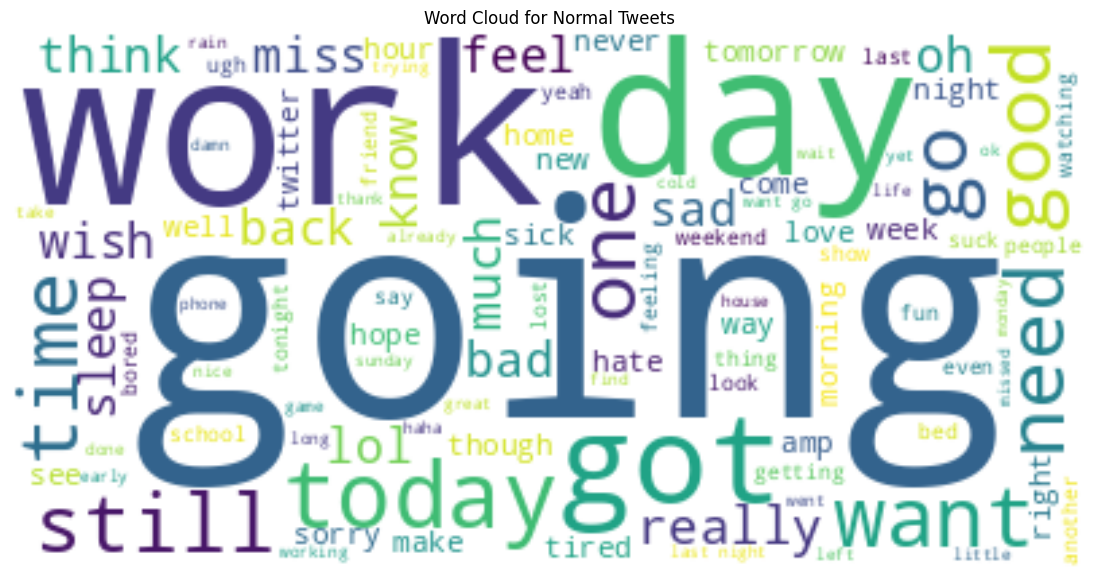

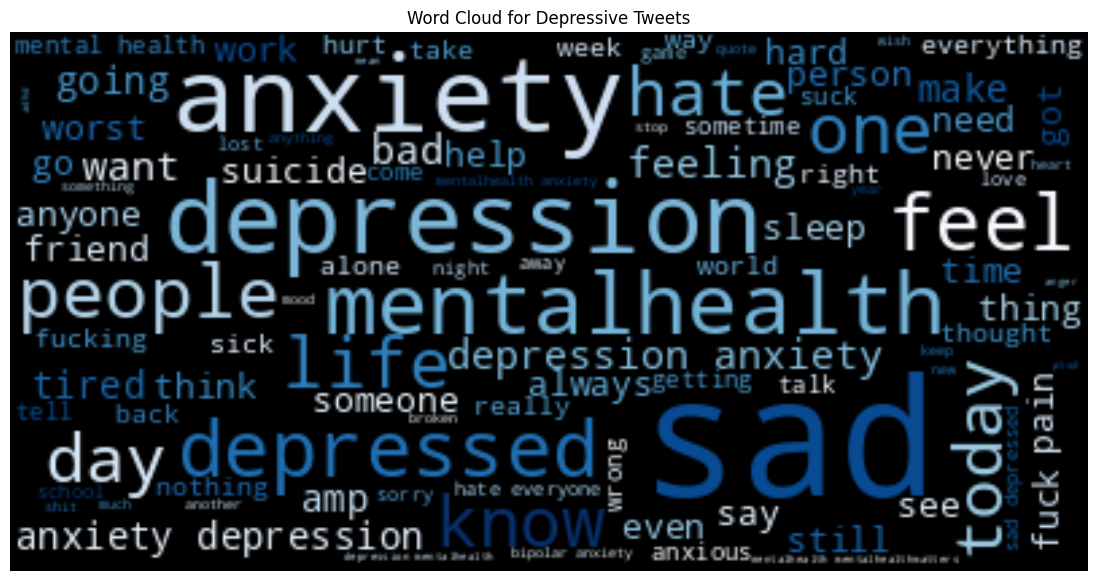

In [14]:
def show_wordcloud(text, title):
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.title(title)
    plt.show()

def show_wordclou_depressive(text, title):
    wordcloud = WordCloud(max_words=100, colormap="Blues").generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.title(title)
    plt.show()


normal_tweets = df[df['label'] == 0]['text']
depressive_tweets = df[df['label'] == 1]['text']

normal_text = ' '.join(normal_tweets)
depressive_text = ' '.join(depressive_tweets)

show_wordcloud(normal_text, "Word Cloud for Normal Tweets")
show_wordclou_depressive(depressive_text, "Word Cloud for Depressive Tweets")

In [15]:
normal_words = list(itertools.chain(*[tweet.split() for tweet in normal_tweets]))
depressive_words = list(itertools.chain(*[tweet.split() for tweet in depressive_tweets]))

normal_word_count = Counter(normal_words)
depressive_word_count = Counter(depressive_words)

print("Most common words in normal tweets:")
print(normal_word_count.most_common(10))
print("\nMost common words in depressive tweets:")
print(depressive_word_count.most_common(10))

Most common words in normal tweets:
[('work', 398), ('going', 373), ('go', 362), ('cannot', 347), ('get', 342), ('day', 311), ('like', 304), ('got', 292), ('want', 289), ('back', 276)]

Most common words in depressive tweets:
[('sad', 2106), ('anxiety', 1212), ('depression', 1143), ('mentalhealth', 736), ('depressed', 475), ('like', 436), ('hate', 335), ('feel', 316), ('cannot', 288), ('life', 273)]


# **Section 3: Feature Extraction**

In [16]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Split the dataset
train_data, validation_data = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
def calculate_proportions(data):
    len_rows = len(data)
    depressive_rows = len(data[data['label'] == 1])
    non_depressive_rows = len(data[data['label'] == 0])
    
    depressive_percentage = (depressive_rows / len_rows) * 100
    non_depressive_percentage = (non_depressive_rows / len_rows) * 100
    
    return depressive_percentage, non_depressive_percentage

train_depressive_percentage, train_normal_percentage = calculate_proportions(train_data)
validation_depressive_percentage, validation_normal_percentage = calculate_proportions(validation_data)

print(f"Development set: Depressive = {train_depressive_percentage:.2f}%, non-Depressive = {train_normal_percentage:.2f}%")
print(f"Validation set: Depressive = {validation_depressive_percentage:.2f}%, non-Depressive = {validation_normal_percentage:.2f}%")

Development set: Depressive = 40.01%, non-Depressive = 59.99%
Validation set: Depressive = 39.95%, non-Depressive = 60.05%


In [19]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
# Fit the vectorizer to the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [20]:
X_train_tfidf

<8000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 66967 stored elements in Compressed Sparse Row format>

In [21]:
X_test_tfidf

<2000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 15869 stored elements in Compressed Sparse Row format>

In [22]:
# save tfidf
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
files.download('/content/tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Section 4: Model Compare**

When selecting a model for your tweet classification task, it's a good idea to start with simple models and then gradually move to more complex ones if needed.

## **Secion4.1: Logistic Regression**


In [23]:
accuracy_scores = []
recall_scores = []
f1_scores = []

In [24]:
# Train a Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test_tfidf)

# Save the result
accuracy_scores.append(accuracy_score(y_test, y_pred_logreg))
recall_scores.append(recall_score(y_test, y_pred_logreg, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_logreg, average='weighted'))

# Evaluate the Logistic Regression model
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg, digits=5))

Logistic Regression
Accuracy: 0.9605
Classification Report:
               precision    recall  f1-score   support

           0    0.96517   0.96919   0.96718      1201
           1    0.95340   0.94743   0.95041       799

    accuracy                        0.96050      2000
   macro avg    0.95929   0.95831   0.95879      2000
weighted avg    0.96047   0.96050   0.96048      2000



In [25]:
# Save the trained SVM model
joblib.dump(logreg, 'logreg_model.pkl')
files.download('/content/logreg_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Secion4.2: KNN**

In [26]:
# Train a K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_tfidf)

# Save the result
accuracy_scores.append(accuracy_score(y_test, y_pred_knn))
recall_scores.append(recall_score(y_test, y_pred_knn, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_knn, average='weighted'))

# Evaluate the K-Nearest Neighbors model
print("K-Nearest Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn, digits=5))

K-Nearest Neighbors
Accuracy: 0.618
Classification Report:
               precision    recall  f1-score   support

           0    0.61131   0.99917   0.75853      1201
           1    0.97297   0.04506   0.08612       799

    accuracy                        0.61800      2000
   macro avg    0.79214   0.52211   0.42233      2000
weighted avg    0.75579   0.61800   0.48991      2000



## **Secion4.3: Support Vector Classifier**

In [27]:
# Train a Support Vector Machines model
svm = SVC()
svm.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_svm = svm.predict(X_test_tfidf)

# Save the result
accuracy_scores.append(accuracy_score(y_test, y_pred_svm))
recall_scores.append(recall_score(y_test, y_pred_svm, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_svm, average='weighted'))

# Evaluate the Support Vector Machines model
print("Support Vector Machines")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm, digits=5))

Support Vector Machines
Accuracy: 0.9735
Classification Report:
               precision    recall  f1-score   support

           0    0.99060   0.96503   0.97765      1201
           1    0.94940   0.98623   0.96746       799

    accuracy                        0.97350      2000
   macro avg    0.97000   0.97563   0.97256      2000
weighted avg    0.97414   0.97350   0.97358      2000



In [28]:
# Save the trained SVM model
joblib.dump(svm, 'svm_model.pkl')
files.download('/content/svm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Secion4.4: Random Forests**

In [29]:
# Train a Random Forests model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test_tfidf)

# Save the result
accuracy_scores.append(accuracy_score(y_test, y_pred_rf))
recall_scores.append(recall_score(y_test, y_pred_rf, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_rf, average='weighted'))

# Evaluate the Random Forests model
print("Random Forests")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, digits=5))

Random Forests
Accuracy: 0.979
Classification Report:
               precision    recall  f1-score   support

           0    0.99742   0.96753   0.98225      1201
           1    0.95329   0.99625   0.97430       799

    accuracy                        0.97900      2000
   macro avg    0.97536   0.98189   0.97827      2000
weighted avg    0.97979   0.97900   0.97907      2000



In [30]:
# Save the trained rf model
joblib.dump(rf, 'rf_model.pkl')
files.download('/content/rf_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Secion4.5: Compare the basic classification models**

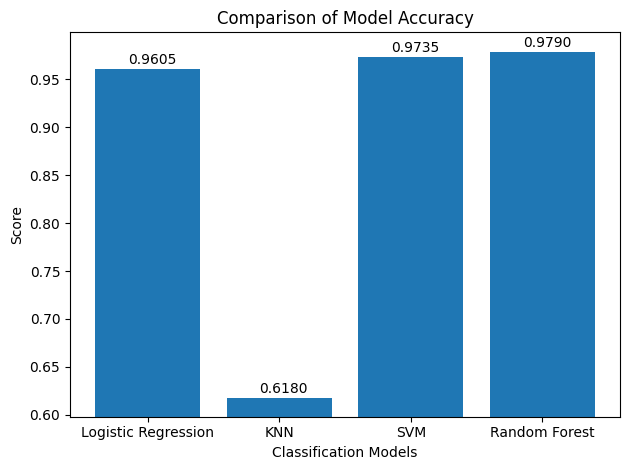

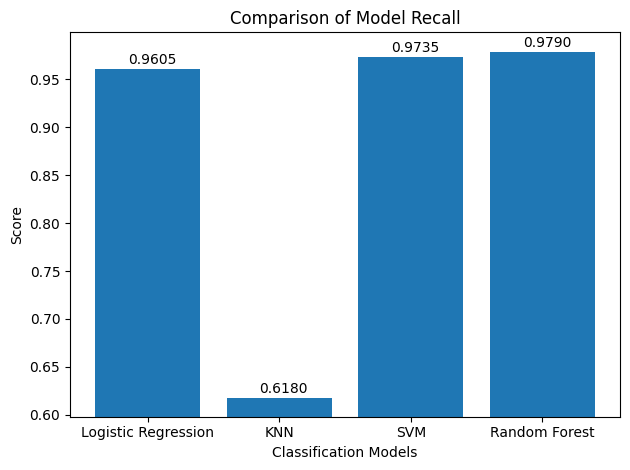

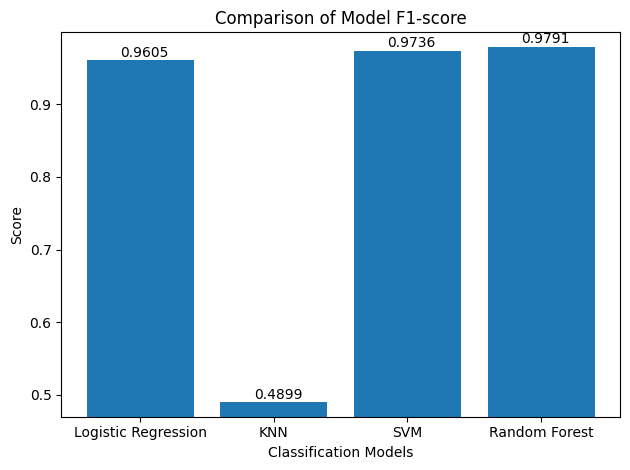

In [31]:
names = ["Logistic Regression", "KNN", "SVM", "Random Forest"]
x = np.arange(len(names))

def plot_metric(metric_name, metric_scores):
    fig, ax = plt.subplots()
    rects = ax.bar(x, metric_scores)
    
    ax.set_xlabel("Classification Models")
    ax.set_ylabel("Score")
    ax.set_title(f"Comparison of Model {metric_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(names)

    # Adjust the y-axis limits for better comparison
    lower_limit = min(metric_scores) - 0.02
    upper_limit = max(metric_scores) + 0.02
    ax.set_ylim(lower_limit, upper_limit)

    # Add the metric value on top of each bar
    for i, v in enumerate(metric_scores):
        ax.text(i - 0.15, v + 0.005, f"{v:.4f}")

    fig.tight_layout()
    plt.show()

# Plot each metric separately
plot_metric("Accuracy", accuracy_scores)
plot_metric("Recall", recall_scores)
plot_metric("F1-score", f1_scores)

## **Secion4.6: Deep Learning Model (LSTM)**



In [32]:
def load_glove_embeddings(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_file = 'glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

In [33]:
max_length = 100  
embedding_dim = 100  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1420100   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,537,477
Trainable params: 117,377
Non-trainable params: 1,420,100
_________________________________________________________________
Epoch 1/5
113/113 [==============================] - 47s 376ms/step - loss: 0.2299 - accuracy: 0.9190 - val_loss: 0.1100 - val_accuracy: 0.9700
Epoch 2/5
113/113 [==============================] - 40s 357ms/step - loss: 0.1192 - accuracy: 0.9597 - val_loss: 0.0994 - val_accuracy: 0.9700
Epoch 3/5
113/11

In [35]:
y_pred_lstm_prob = model.predict(X_test_padded)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int).flatten()

print("LSTM")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_lstm, digits=5))

63/63 [==============================] - 4s 54ms/step
LSTM
Accuracy: 0.9705
Classification Report:
               precision    recall  f1-score   support

           0    0.97583   0.97502   0.97543      1201
           1    0.96250   0.96370   0.96310       799

    accuracy                        0.97050      2000
   macro avg    0.96917   0.96936   0.96926      2000
weighted avg    0.97051   0.97050   0.97050      2000



In [36]:
joblib.dump(model, 'lstm_model.pkl')
files.download('/content/lstm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>